## Prepare the workspace

In [1]:
# Before you proceed, update the PATH
import os
os.environ['PATH'] = f"{os.environ['PATH']}:/root/.local/bin"
os.environ['PATH'] = f"{os.environ['PATH']}:/opt/conda/lib/python3.6/site-packages"
# Restart the Kernel at this point. 

In [2]:
# Do not execute the commands below unless you have restart the Kernel after updating the PATH. 
!python -m pip install torch==1.0.0

Defaulting to user installation because normal site-packages is not writeable
ERROR: Could not find a version that satisfies the requirement torch==1.0.0 (from versions: 1.11.0, 1.12.0, 1.12.1, 1.13.0, 1.13.1, 2.0.0, 2.0.1, 2.1.0, 2.1.1, 2.1.2)
ERROR: No matching distribution found for torch==1.0.0


In [3]:
# Check torch version and CUDA status if GPU is enabled.
import torch
print(torch.__version__)
print(torch.cuda.is_available()) # Should return True when GPU is enabled. 

2.0.1
True


# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [4]:
# Imports here
import pandas as pd
import numpy as np
import seaborn as sns

from torch import nn, tensor, optim
import torch.nn.functional as F

from torch.autograd import Variable
from torchvision import datasets, transforms

import torchvision.models as models

import argparse
from collections import OrderedDict

import json
import PIL
from PIL import Image
import time

## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). 

If you do not find the `flowers/` dataset in the current directory, **/workspace/home/aipnd-project/**, you can download it using the following commands. 

```bash
!wget 'https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz'
!unlink flowers
!mkdir flowers && tar -xzf flower_data.tar.gz -C flowers
```


## Data Description
The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [5]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [6]:
# TODO: Define your transforms for the training, validation, and testing sets
data_transforms = { 
    'train': transforms.Compose([
        transforms.RandomResizedCrop(size=224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.485,0.456,0.406],
                             std = [0.229,0.224,0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.485,0.456,0.406],
                             std = [0.229,0.224,0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.485,0.456,0.406],
                             std = [0.229,0.224,0.225])
    ])
}

# TODO: Load the datasets with ImageFolder
image_datasets = {
    'train': datasets.ImageFolder(train_dir, transform=data_transforms['train']),
    'valid': datasets.ImageFolder(valid_dir, transform=data_transforms['valid']),
    'test': datasets.ImageFolder(test_dir, transform=data_transforms['test'])
}

# TODO: Using the image datasets and the trainforms, define the dataloaders
# dataloaders = 
train_loader = torch.utils.data.DataLoader(image_datasets['train'], batch_size=64, shuffle=True)
validation_loader = torch.utils.data.DataLoader(image_datasets['valid'], batch_size =64,shuffle = True)
test_loader = torch.utils.data.DataLoader(image_datasets['test'], batch_size = 64, shuffle = True)

# Size of Loaders, to be used for calculating Average Loss and Accuracy
train_Loader_size = len(train_loader)
valid_Loader_size = len(validation_loader)
test_loader_size = len(test_loader)

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [7]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

One last important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to
GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module.

## Note for Workspace users: 
If your network is over 1 GB when saved as a checkpoint, there might be issues with saving backups in your workspace. Typically this happens with wide dense layers after the convolutional layers. If your saved checkpoint is larger than 1 GB (you can open a terminal and check with `ls -lh`), you should reduce the size of your hidden layers and train again.

In [8]:
# TODO: Build and train your network

# Load the pretrained VGG16 model for transfer learning
pretrained_model = models.vgg16(pretrained=True)

# Freeze the parameters of the pretrained layers for efficiency
for parameter in pretrained_model.parameters():
    parameter.requires_grad = False

# Create a new classifier to replace the final layer of the pretrained model
classifier = nn.Sequential(OrderedDict([
    ('first_hidden_layer', nn.Linear(25088, 120)),
    ('first_relu', nn.ReLU()),
    ('dropout', nn.Dropout(0.5)),
    ('second_hidden_layer', nn.Linear(120, 90)),
    ('second_relu', nn.ReLU()),
    ('third_hidden_layer', nn.Linear(90, 70)),
    ('third_relu', nn.ReLU()),
    ('output_layer', nn.Linear(70, 102)),
    ('output_logsoftmax', nn.LogSoftmax(dim=1))  # For using NLLLoss
]))

# Replace the classifier of the pretrained model with the new one
pretrained_model.classifier = classifier

# Move the model to the GPU if available
if torch.cuda.is_available():
    pretrained_model = pretrained_model.cuda()

# Define the loss function and optimizer
criterion = nn.NLLLoss()
optimizer = optim.Adam(pretrained_model.classifier.parameters(), lr=0.001)

# Training loop
epochs = 5
for epoch in range(epochs):
    print(f"Epoch: {epoch+1}/{epochs}")

    # Set model to training mode
    pretrained_model.train()

    # Initialize training metrics
    training_loss = 0.0
    training_accuracy = 0.0

    # Iterate over training batches
    for batch_index, (images, labels) in enumerate(train_loader):
        images = images.to('cuda')
        labels = labels.to('cuda')

        # Zero out gradients from previous step
        optimizer.zero_grad()

        # Forward pass
        outputs = pretrained_model(images)

        # Compute loss
        batch_loss = criterion(outputs, labels)

        # Backpropagation
        batch_loss.backward()

        # Update parameters
        optimizer.step()

        # Accumulate training metrics
        training_loss += batch_loss.item() * images.size(0)

        _, predicted_classes = torch.max(outputs.data, 1)
        correct_predictions = (predicted_classes == labels.data).sum().item()
        training_accuracy += correct_predictions

        print(f"Batch {batch_index+1:03d}, Loss: {batch_loss.item():.4f}, Accuracy: {correct_predictions/images.size(0):.4f}")

    # Calculate and print average training loss and accuracy
    print(f"Epoch {epoch+1}: Average Training Loss: {training_loss/len(train_loader.dataset):.4f}, Average Training Accuracy: {training_accuracy/len(train_loader.dataset):.4f}")


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /home/student/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 254MB/s]  


Epoch: 1/5
Batch 001, Loss: 4.6237, Accuracy: 0.0000
Batch 002, Loss: 4.5860, Accuracy: 0.0156
Batch 003, Loss: 4.6650, Accuracy: 0.0000
Batch 004, Loss: 4.5446, Accuracy: 0.0312
Batch 005, Loss: 4.6547, Accuracy: 0.0000
Batch 006, Loss: 4.6096, Accuracy: 0.0156
Batch 007, Loss: 4.6484, Accuracy: 0.0312
Batch 008, Loss: 4.5696, Accuracy: 0.0625
Batch 009, Loss: 4.5405, Accuracy: 0.0000
Batch 010, Loss: 4.4846, Accuracy: 0.0625
Batch 011, Loss: 4.5882, Accuracy: 0.0312
Batch 012, Loss: 4.5069, Accuracy: 0.0469
Batch 013, Loss: 4.5103, Accuracy: 0.0312
Batch 014, Loss: 4.4689, Accuracy: 0.0469
Batch 015, Loss: 4.5698, Accuracy: 0.0312
Batch 016, Loss: 4.3991, Accuracy: 0.1094
Batch 017, Loss: 4.5200, Accuracy: 0.0469
Batch 018, Loss: 4.4079, Accuracy: 0.0938
Batch 019, Loss: 4.4344, Accuracy: 0.0781
Batch 020, Loss: 4.6406, Accuracy: 0.0156
Batch 021, Loss: 4.3942, Accuracy: 0.0781
Batch 022, Loss: 4.4409, Accuracy: 0.0469
Batch 023, Loss: 4.4194, Accuracy: 0.0469
Batch 024, Loss: 4.4163

## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [9]:
# TODO: Do validation on the test set

# Validation on the validation set
with torch.no_grad():  # Disable gradient tracking for validation

    # Set model to evaluation mode
    pretrained_model.eval()

    # Initialize validation metrics
    validation_loss = 0.0
    validation_accuracy = 0.0

    # Iterate over validation batches
    for batch_index, (images, labels) in enumerate(validation_loader):
        images = images.to('cuda')
        labels = labels.to('cuda')

        # Forward pass
        outputs = pretrained_model(images)

        # Compute loss
        batch_loss = criterion(outputs, labels)

        # Accumulate validation metrics
        validation_loss += batch_loss.item() * images.size(0)

        _, predicted_classes = torch.max(outputs.data, 1)
        correct_predictions = (predicted_classes == labels.data).sum().item()
        validation_accuracy += correct_predictions

        print(f"Validation Batch {batch_index+1:03d}, Loss: {batch_loss.item():.4f}, Accuracy: {correct_predictions/images.size(0):.4f}")

    # Calculate and print average validation loss and accuracy
    print(f"Epoch {epoch+1}: Average Validation Loss: {validation_loss/len(validation_loader.dataset):.4f}, Average Validation Accuracy: {validation_accuracy/len(validation_loader.dataset):.4f}")


    # Initialize counters for correct predictions and total samples
num_correct_predictions = 0
total_samples_processed = 0

# Disable gradient tracking for evaluation
with torch.no_grad():

    # Set model to evaluation mode
    pretrained_model.eval()

    # Iterate through test data in batches
    for batch_index, (test_images, test_labels) in enumerate(test_loader):  # Use test_loader here

        # Move images and labels to GPU (if available)
        test_images = test_images.to('cuda')
        test_labels = test_labels.to('cuda')

        # Generate model predictions for the batch
        model_outputs = pretrained_model(test_images)

        # Get predicted classes for each image
        _, predicted_classes = torch.max(model_outputs.data, 1)

        # Update counters for correct predictions and total samples
        num_correct_predictions += (predicted_classes == test_labels).sum().item()
        total_samples_processed += test_labels.size(0)

# Calculate and print overall test accuracy
test_accuracy = 100 * num_correct_predictions / total_samples_processed
print('Accuracy on test images: %.2f%%' % test_accuracy)


Validation Batch 001, Loss: 0.9444, Accuracy: 0.7656
Validation Batch 002, Loss: 0.6439, Accuracy: 0.8438
Validation Batch 003, Loss: 1.4188, Accuracy: 0.6562
Validation Batch 004, Loss: 0.8070, Accuracy: 0.7656
Validation Batch 005, Loss: 1.0393, Accuracy: 0.6875
Validation Batch 006, Loss: 0.9806, Accuracy: 0.6875
Validation Batch 007, Loss: 1.0289, Accuracy: 0.7188
Validation Batch 008, Loss: 0.7837, Accuracy: 0.7656
Validation Batch 009, Loss: 0.9208, Accuracy: 0.7188
Validation Batch 010, Loss: 0.9444, Accuracy: 0.7031
Validation Batch 011, Loss: 0.8393, Accuracy: 0.7656
Validation Batch 012, Loss: 1.0459, Accuracy: 0.6875
Validation Batch 013, Loss: 0.9038, Accuracy: 0.7400
Epoch 5: Average Validation Loss: 0.9469, Average Validation Accuracy: 0.7311
Accuracy on test images: 70.21%


## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [15]:
# TODO: Save the checkpoint 
pretrained_model.class_to_idx = image_datasets['train'].class_to_idx
torch.save({'structure' :'alexnet',
            'hidden_layer1':120,
             'droupout':0.5,
             'epochs':12,
             'state_dict':pretrained_model.state_dict(),
             'class_to_idx':pretrained_model.class_to_idx,
             'optimizer_dict':optimizer.state_dict()},
             'checkpoint.pth')

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [16]:
# TODO: Write a function that loads a checkpoint and rebuilds the model
def load_checkpoint(checkpoint_path='checkpoint.pth'):
    """
    Loads a saved model checkpoint from disk.

    Args:
        checkpoint_path (str, optional): Path to the checkpoint file. Defaults to 'checkpoint.pth'.

    Returns:
        torchvision.models.vgg16: The loaded model.
    """

    # Load the checkpoint data from disk
    checkpoint_data = torch.load(checkpoint_path)

    # Load the pretrained VGG16 model
    pretrained_model = models.vgg16(pretrained=True)

    # Freeze parameters of pretrained layers to avoid unnecessary updates
    for parameter in pretrained_model.parameters():
        parameter.requires_grad = False

    # Restore class mappings and model state from the checkpoint
    pretrained_model.class_to_idx = checkpoint_data['class_to_idx']
    pretrained_model.load_state_dict(checkpoint_data['state_dict'])

    return pretrained_model



# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [17]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # TODO: Process a PIL image for use in a PyTorch model
    """
    Preprocesses a PIL image for use in a PyTorch model by performing:
    - Scaling the image to have a shorter side of 256 pixels.
    - Cropping a 244x244 pixel region from the center of the image.
    - Normalizing the pixel values to the range [0, 1].
    - Transposing the image to have the color channel as the first dimension.

    Args:
        image_path (str): Path to the input image.

    Returns:
        numpy.ndarray: The preprocessed image as a NumPy array,
                       ready for input to a PyTorch model.
    """

    # Load the image using PIL
    input_image = PIL.Image.open(image_path)

    # Extract original dimensions
    original_width, original_height = input_image.size

    # Scale the image to have a shorter side of 256 pixels
    if original_width < original_height:
        scaling_size = (256, 256 * 600)  # Preserve aspect ratio
    else:
        scaling_size = (256 * 600, 256)
    input_image.thumbnail(scaling_size)

    # Crop a 244x244 pixel region from the center   
    center_x = original_width / 2
    center_y = original_height / 2
    crop_box = (center_x - 122, center_y - 122, center_x + 122, center_y + 122)
    cropped_image = input_image.crop(crop_box)

    # Convert to NumPy array and normalize pixel values
    image_array = np.array(cropped_image) / 255.0

    # Normalize using mean and standard deviation
    normalization_mean = [0.485, 0.456, 0.406]
    normalization_std = [0.229, 0.224, 0.225]
    normalized_image_array = (image_array - normalization_mean) / normalization_std

    # Transpose to place color channel first for PyTorch
    processed_image_array = normalized_image_array.transpose(2, 0, 1)

    return processed_image_array


To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [33]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [44]:
def predict(image_path, trained_model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # TODO: Implement the code to predict the class from an image file
    """Predicts the top k classes for a given image using a trained PyTorch model.

    Args:
        image_path (str): Path to the image to be classified.
        trained_model (torch.nn.Module): The trained PyTorch model.
        top_k_classes (int, optional): The number of top classes to return. Defaults to 5.

    Returns:
        tuple: (top_probabilities, top_class_labels, top_class_names)
    """

    # Move model to CPU for prediction
    trained_model.to("cpu")

    # Set model to evaluation mode
    trained_model.eval()

    # Preprocess the image
    preprocessed_image = process_image(image_path)

    # Convert the image to a PyTorch tensor
    tensor_image = torch.from_numpy(preprocessed_image).unsqueeze(0).float().to("cpu")

    # Generate model predictions
    log_probabilities = trained_model(tensor_image)
    linear_probabilities = torch.exp(log_probabilities)

    # Get the top k probabilities and corresponding class indices
    top_probs, top_class_indices = linear_probabilities.topk(topk)

    # Convert top class indices to class labels
    index_to_class_mapping = {value: key for key, value in trained_model.class_to_idx.items()}
    top_class_labels = [index_to_class_mapping[class_idx] for class_idx in top_class_indices.tolist()[0]]

    # Map class labels to class names (assuming you have a mapping dictionary called 'cat_to_name')
    top_class_names = [cat_to_name[class_label] for class_label in top_class_labels]

    return top_probs.tolist()[0], top_class_labels, top_class_names


## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

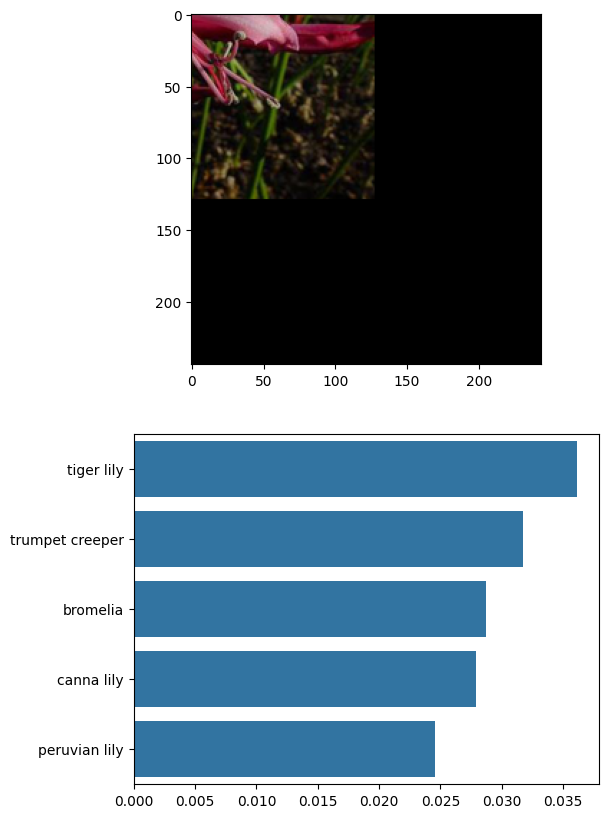

In [45]:
# TODO: Display an image along with the top 5 classes
import matplotlib.pyplot as plt
# Define image path
image_path = "flowers/test/37/image_03734.jpg"

# Set up plot
plt.figure(figsize = (6,10))
ax = plt.subplot(2,1,1)

# Set up title
flower_num = image_path.split('/')[2]
title_ = cat_to_name[flower_num]

# Plot flower
img = process_image(image_path)
imshow(img, ax, title_);

# Make prediction
probs, labs, flowers = predict(image_path, pretrained_model) 

# Plot bar chart
plt.subplot(2,1,2)
sns.barplot(x=probs, y=flowers, color=sns.color_palette()[0]);
plt.show()

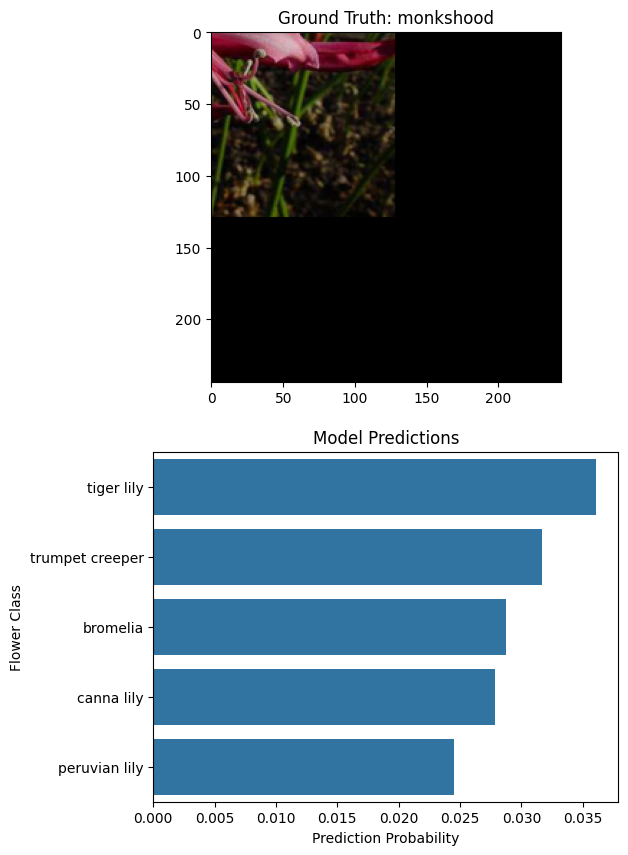

In [53]:
# Specify the path to the image to be analyzed
image_file_path = "flowers/test/9/image_06413.jpg"

# Create a figure for visualization with appropriate dimensions
plt.figure(figsize=(6, 10))

# Plot the original image along with its ground truth label
plt.subplot(2, 1, 1)

# Extract the ground truth label from the image path
ground_truth_flower_label = image_file_path.split('/')[2]
ground_truth_flower_name = cat_to_name[ground_truth_flower_label]

# Load and preprocess the image
preprocessed_image = process_image(image_file_path)

# Display the preprocessed image with its ground truth label
ax = plt.subplot(2,1,1)
imshow(preprocessed_image,ax,ground_truth_flower_name)

plt.title(f"Ground Truth: {ground_truth_flower_name}")

# Generate model predictions for the image
top_probabilities, top_class_labels, top_class_names = predict(
    image_file_path, pretrained_model
)

# Plot the model's prediction probabilities as a bar chart
plt.subplot(2, 1, 2)
sns.barplot(x=top_probabilities, y=top_class_names, color=sns.color_palette()[0])
plt.title("Model Predictions")
plt.xlabel("Prediction Probability")
plt.ylabel("Flower Class")

plt.show()


## Reminder for Workspace users
If your network becomes very large when saved as a checkpoint, there might be issues with saving backups in your workspace. You should reduce the size of your hidden layers and train again. 
    
We strongly encourage you to delete these large interim files and directories before navigating to another page or closing the browser tab.

In [ ]:
# TODO remove .pth files or move it to a temporary `~/opt` directory in this Workspace